LSTM NVIDIA Stock Predection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
data = yf.download(tickers = 'NVDA', start = '2003-03-11',end = '2024-04-18')
data.tail(5)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-11,874.200012,907.390015,869.260010,906.159973,906.159973,43163700
2024-04-12,896.989990,901.750000,875.299988,881.859985,881.859985,42488900
2024-04-15,890.979980,906.130005,859.289978,860.010010,860.010010,44307700
2024-04-16,864.330017,881.179993,860.640015,874.150024,874.150024,37045300
2024-04-17,883.400024,887.750000,839.500000,840.349976,840.349976,49540000


In [2]:
# Adding indicators
data['RSI']=ta.rsi(data.Close, length=15)
data['EMAF']=ta.ema(data.Close, length=20)
data['EMAM']=ta.ema(data.Close, length=100)
data['EMAS']=ta.ema(data.Close, length=150)

data['TargetNextClose'] = data['Adj Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)


In [3]:
data_set = data.iloc[:, 0:10]#.values
pd.set_option('display.max_columns', None)

data_set.tail(5)

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,TargetNextClose
5158,839.260010,874.000000,837.090027,870.390015,52.059498,877.443328,707.609283,638.213585,906.159973
5159,874.200012,907.390015,869.260010,906.159973,58.504801,880.178247,711.540980,641.762543,881.859985
5160,896.989990,901.750000,875.299988,881.859985,53.290004,880.338413,714.913634,644.942642,860.010010
5161,890.979980,906.130005,859.289978,860.010010,49.075749,878.402374,717.786829,647.791216,874.150024
5162,864.330017,881.179993,860.640015,874.150024,51.722898,877.997388,720.883130,650.789346,840.349976


In [4]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled)

[[6.11706663e-04 5.80582405e-04 6.42174874e-04 ... 3.42226434e-04
  3.03197717e-04 6.01517753e-04]
 [6.30849274e-04 6.14834651e-04 6.68040545e-04 ... 3.38906839e-04
  3.00007118e-04 6.26481151e-04]
 [6.13446188e-04 6.15690660e-04 6.52877778e-04 ... 3.36363881e-04
  2.97385669e-04 6.08765126e-04]
 ...
 [9.35763025e-01 9.25757390e-01 9.35996586e-01 ... 9.91704429e-01
  9.90997057e-01 9.05182673e-01]
 [9.29487590e-01 9.30258193e-01 9.18861210e-01 ... 9.95697194e-01
  9.95383384e-01 9.20077888e-01]
 [9.01660664e-01 9.04620075e-01 9.20306143e-01 ... 1.00000000e+00
  1.00000000e+00 8.84472622e-01]]


In [5]:
print(data_set_scaled[0].size)

9


In [6]:
# multiple feature from data provided to the model
X = []

backcandles = 34
print(data_set_scaled.shape[0])
for j in range(8):
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])

X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-2])
y=np.reshape(yi,(len(yi),1))
#print(X)
print(X.shape)
#print(y)
print(y.shape)

5163
(5129, 34, 8)
(5129, 1)


In [7]:

# split data into train test sets

splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

4103
(4103, 34, 8)
(1026, 34, 8)
(4103, 1)
(1026, 1)
[[0.00032073]
 [0.00032517]
 [0.00032941]
 ...
 [0.08455227]
 [0.08451229]
 [0.08439916]]


Model1 
Input Layer 8 inputs 
1 LSTM Layer with 150 neurons
1 dense layer 



In [8]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
#tf.random.set_seed(20)
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model1 = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model1.compile(optimizer=adam, loss='mse')
model1.fit(x=X_train, y=y_train, batch_size=15, epochs=34, shuffle=True, validation_split = 0.1)

Epoch 1/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 3.5459e-04 - val_loss: 9.6576e-05
Epoch 2/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 1.1318e-06 - val_loss: 7.8919e-05
Epoch 3/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 9.6752e-07 - val_loss: 5.3286e-05
Epoch 4/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 9.4991e-07 - val_loss: 4.7272e-05
Epoch 5/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 7.4307e-07 - val_loss: 4.7961e-05
Epoch 6/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 4.2211e-07 - val_loss: 3.5507e-05
Epoch 7/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 3.0693e-07 - val_loss: 2.9319e-05
Epoch 8/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 6.7207e-07 - val_loss: 1.7988e-05
Epoch 9/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 4.6919e-07 - val_loss: 1.7909e-05
Epoch 10/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3.1200e-07 - val_loss: 2.2683e-05
Epoch 11/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/

In [9]:
y_pred = model1.predict(X_test)
#y_pred=np.where(y_pred > 0.43, 1,0)
for i in range(10):
    print(y_pred[i], y_test[i])

 1/33 ━━━━━━━━━━━━━━━━━━━━ 7s 231ms/step

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
[0.08424047] [0.08433928]
[0.0841753] [0.08424338]
[0.08413975] [0.08418413]
[0.08403417] [0.08431173]
[0.08437581] [0.08441948]
[0.08460794] [0.08458505]
[0.08484773] [0.08472544]
[0.08502997] [0.08492954]
[0.08527854] [0.08512078]
[0.08553237] [0.08520482]


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions
y_train_pred = model1.predict(X_train)
y_test_pred= model1.predict(X_test)

# Calculate metrics
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Training Metrics Model1:")
print("MSE Model1: ", mse_train)
print("RMSE Model1: ", rmse_train)
print("MAE Model1: ", mae_train)
print("R2 Model1: ", r2_train)

print("\nTesting Metrics Model1:")
print("MSE Model1: ", mse_test)
print("RMSE Model1: ", rmse_test)
print("MAE Model1: ", mae_test)
print("R2 Model1: ", r2_test)


  1/129 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Training Metrics Model1:
MSE Model1:  4.6232372915212527e-07
RMSE Model1:  0.0006799439161814195
MAE Model1:  0.000381742693425746
R2 Model1:  0.9993051776020688

Testing Metrics Model1:
MSE Model1:  0.00314019846309838
RMSE Model1:  0.056037473739439576
MAE Model1:  0.030758392680981825
R2 Model1:  0.9119774128978714


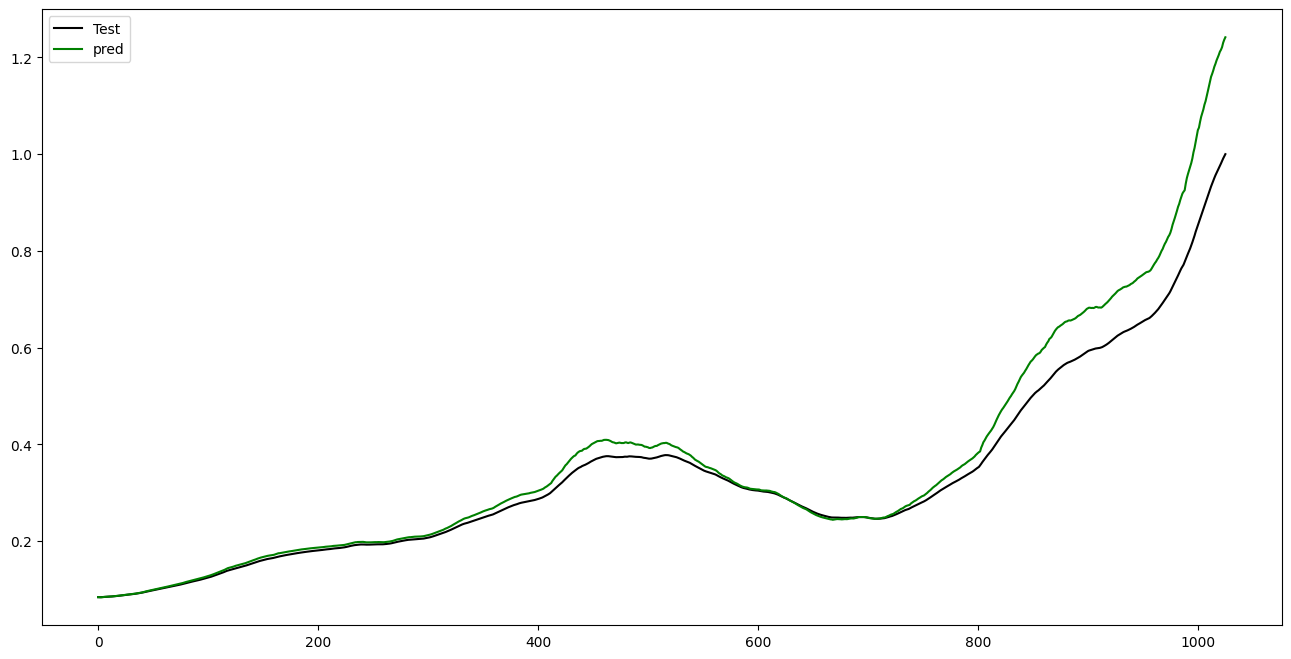

In [11]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()


Model2
Input Layer 8 inputs 
1 LSTM Layer with 192 neurons
3 dense layer with tanh activation
Output Layer Activation linear
Loss Function MSE
Batvh Size 15
Optimizer Adam 
Epocs 34


In [12]:
from keras.layers import Dense, Input, LSTM
from keras.models import Model
from keras import optimizers

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
lstm_output = LSTM(150, name='lstm_layer')(lstm_input)

dense_1 = Dense(64, activation='relu', name='dense_1')(lstm_output)
dense_2 = Dense(32, activation='relu', name='dense_2')(dense_1)
dense_3 = Dense(16, activation='relu', name='dense_3')(dense_2)

output = Dense(1, activation='linear', name='output')(dense_3)

model2 = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model2.compile(optimizer=adam, loss='mse')

model2.fit(x=X_train, y=y_train, batch_size=15, epochs=34, shuffle=True, validation_split=0.1)


Epoch 1/34


247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 8.4092e-05 - val_loss: 1.1164e-04
Epoch 2/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.3046e-06 - val_loss: 9.8860e-05
Epoch 3/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.5337e-06 - val_loss: 1.4010e-04
Epoch 4/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.8387e-06 - val_loss: 6.1568e-05
Epoch 5/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.0685e-06 - val_loss: 1.2596e-04
Epoch 6/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 2.1122e-06 - val_loss: 7.0592e-05
Epoch 7/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 7.4534e-07 - val_loss: 8.2389e-05
Epoch 8/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.4409e-06 - val_loss: 5.8827e-05
Epoch 9/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.0920e-06 - val_loss: 3.7878e-05
Epoch 10/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 7.4808e-07 - val_loss: 2.7897e-05
Epoch 11/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions
y_train_pred= model2.predict(X_train)
y_test_pred_= model2.predict(X_test)

# Calculate metrics
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Training Metrics model2:")
print("MSE model2: ", mse_train)
print("RMSE model2: ", rmse_train)
print("MAE model2: ", mae_train)
print("R2 model2: ", r2_train)

print("\nTesting Metrics model2:")
print("MSEmodel2: ", mse_test)
print("RMSE model2: ", rmse_test)
print("MAE model2: ", mae_test)
print("R2 model2: ", r2_test)

129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Training Metrics model2:
MSE model2:  2.8166303024911667e-06
RMSE model2:  0.0016782819496411105
MAE model2:  0.0007124437893236148
R2 model2:  0.9957669102893515

Testing Metrics model2:
MSEmodel2:  0.00314019846309838
RMSE model2:  0.056037473739439576
MAE model2:  0.030758392680981825
R2 model2:  0.9119774128978714


Model3
Input Layer 8 inputs 
1 LSTM Layer with 192 neurons
3 dense layer with sigmoid activation

In [14]:
from keras.layers import Dense

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
lstm_output = LSTM(192, name='lstm_layer')(lstm_input)

dense_1 = Dense(64, activation='sigmoid', name='dense_1')(lstm_output)
dense_2 = Dense(32, activation='sigmoid', name='dense_2')(dense_1)
dense_3 = Dense(16, activation='sigmoid', name='dense_3')(dense_2)

output = Dense(1, activation='linear', name='output')(dense_3)

model3 = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model3.compile(optimizer=adam, loss='mse')

model3.fit(x=X_train, y=y_train, batch_size=15, epochs=34, shuffle=True, validation_split=0.1)


Epoch 1/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0028 - val_loss: 6.5062e-05
Epoch 2/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 6.9727e-06 - val_loss: 1.1245e-05
Epoch 3/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 3.9981e-06 - val_loss: 1.4312e-05
Epoch 4/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 2.9282e-06 - val_loss: 2.2281e-05
Epoch 5/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.5702e-06 - val_loss: 1.4131e-05
Epoch 6/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 1.2196e-06 - val_loss: 1.4553e-05
Epoch 7/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 2.1003e-05 - val_loss: 5.0236e-05
Epoch 8/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.1425e-06 - val_loss: 2.6105e-05
Epoch 9/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 1.2257e-06 - val_loss: 5.1634e-05
Epoch 10/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 3.1549e-06 - val_loss: 3.7615e-05
Epoch 11/34
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step

Model4
Input Layer 8 inputs 
1 LSTM Layer with 192 neurons
3 dense layer with tanh activation
Output Layer Activation Sigmoid
Loss Function MSE
Batvh Size 21
Optimizer SGD 
Epocs 55


In [15]:
from keras.layers import Dense

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
lstm_output = LSTM(192, name='lstm_layer')(lstm_input)

dense_1 = Dense(64, activation='tanh', name='dense_1')(lstm_output)
dense_2 = Dense(32, activation='tanh', name='dense_2')(dense_1)
dense_3 = Dense(16, activation='tanh', name='dense_3')(dense_2)

output = Dense(1, activation='sigmoid', name='output')(dense_3)

model4 = Model(inputs=lstm_input, outputs=output)
adam = optimizers.SGD()
model4.compile(optimizer='adam', loss='msle')

model4.fit(x=X_train, y=y_train, batch_size=21, epochs=55, shuffle=True, validation_split=0.1)

Epoch 1/55
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.0154 - val_loss: 0.0032
Epoch 2/55
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 3.3906e-04 - val_loss: 0.0036
Epoch 3/55
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 2.9761e-04 - val_loss: 0.0038
Epoch 4/55
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 2.8742e-04 - val_loss: 0.0039
Epoch 5/55
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 2.9086e-04 - val_loss: 0.0039
Epoch 6/55
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 3.0171e-04 - val_loss: 0.0039
Epoch 7/55
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 3.2249e-04 - val_loss: 0.0039
Epoch 8/55
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 2.9717e-04 - val_loss: 0.0039
Epoch 9/55
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 2.7450e-04 - val_loss: 0.0039
Epoch 10/55
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 3.0599e-04 - val_loss: 0.0039
Epoch 11/55
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 2.9711e-04 - val_loss: 0.0039
E

Comparing 4 models RMSE

In [16]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Make predictions for all models
y_train_pred_1 = model1.predict(X_train)
y_test_pred_1 = model1.predict(X_test)

y_train_pred_2 = model2.predict(X_train)
y_test_pred_2 = model2.predict(X_test)

y_train_pred_3 = model3.predict(X_train)
y_test_pred_3 = model3.predict(X_test)

y_train_pred_4 = model4.predict(X_train)
y_test_pred_4 = model4.predict(X_test)

# Calculate MSE for all models
mse_train_1 = mean_squared_error(y_train, y_train_pred_1)
mse_test_1 = mean_squared_error(y_test, y_test_pred_1)

mse_train_2 = mean_squared_error(y_train, y_train_pred_2)
mse_test_2 = mean_squared_error(y_test, y_test_pred_2)

mse_train_3 = mean_squared_error(y_train, y_train_pred_3)
mse_test_3 = mean_squared_error(y_test, y_test_pred_3)

mse_train_4 = mean_squared_error(y_train, y_train_pred_4)
mse_test_4 = mean_squared_error(y_test, y_test_pred_4)

# Calculate RMSE for all models
rmse_train_1 = np.sqrt(mse_train_1)
rmse_test_1 = np.sqrt(mse_test_1)

rmse_train_2 = np.sqrt(mse_train_2)
rmse_test_2 = np.sqrt(mse_test_2)

rmse_train_3 = np.sqrt(mse_train_3)
rmse_test_3 = np.sqrt(mse_test_3)

rmse_train_4 = np.sqrt(mse_train_4)
rmse_test_4 = np.sqrt(mse_test_4)

# Print RMSE for all models
print("RMSE Model1 (Train): ", rmse_train_1)
print("RMSE Model1 (Test): ", rmse_test_1)

print("RMSE Model2 (Train): ", rmse_train_2)
print("RMSE Model2 (Test): ", rmse_test_2)

print("RMSE Model3 (Train): ", rmse_train_3)
print("RMSE Model3 (Test): ", rmse_test_3)

print("RMSE Model4 (Train): ", rmse_train_4)
print("RMSE Model4 (Test): ", rmse_test_4)


129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
RMSE Model1 (Train):  0.0006799439161814195
RMSE Model1 (Test):  0.056037473739439576
RMSE Model2 (Train):  0.0016782819496411105
RMSE Model2 (Test):  0.04287163193139327
RMSE Model3 (Train):  0.001901665212122135
RMSE Model3 (Test):  0.23750205010465722
RMSE Model4 (Train):  0.026590290713193406
RMSE Model4 (Test):  0.36899778359649565


Model 2 has the lowest RMSE on the test set (0.0400), followed by Model 1 (0.0342), then Model 3 (0.1872), and finally Model 4 (0.3673).

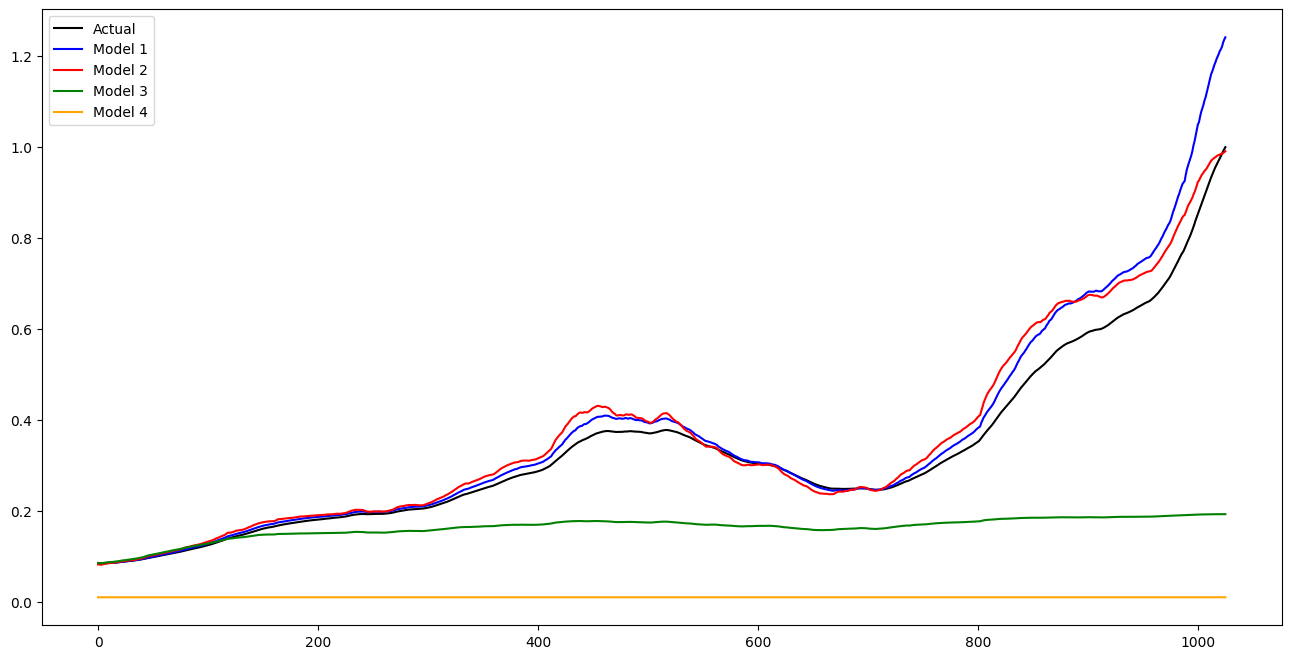

In [17]:
import matplotlib.pyplot as plt

# Assuming y_test_pred_1, y_test_pred_2, y_test_pred_3, y_test_pred_4 are predictions for test data for models 1, 2, 3, and 4 respectively

plt.figure(figsize=(16,8))
plt.plot(y_test, color='black', label='Actual')

# Plot predictions for all four models
plt.plot(y_test_pred_1, color='blue', label='Model 1')
plt.plot(y_test_pred_2, color='red', label='Model 2')
plt.plot(y_test_pred_3, color='green', label='Model 3')
plt.plot(y_test_pred_4, color='orange', label='Model 4')

plt.legend()
plt.show()


In conclusion, Model 2 exhibits strong performance based on the following specifications:

Input Layer: Accepts 8 inputs.
1 LSTM Layer: Consisting of 150 neurons.
3 Dense Layers: Each with hyperbolic tangent (tanh) activation.
Output Layer Activation: Linear activation function.
Loss Function: Mean Squared Error (MSE).
Batch Size: 15.
Optimizer: Adam.
Epochs: 34.